# An Application of Bayes Theorem to Geostatistical Mapping

<i>Jared Deutsch and Clayton Deutsch, 2018</i>

This notebook implements the Geostatistics Lesson <a href="http://geostatisticslessons.com/lessons/bayesmapping">An Application of Bayes Theroem to Geostatistical Mapping</a>. This code is provided for educational purposes and should be reviewed jointly with the lesson. 

Learning Objectives:
- Review Bayes Theorem with an application in geostatistics.
- Motivate Bayes Theorem for secondary data integration.
- Understand a workflow for geostatistical modeling with secondary data.

In [1]:
print('Package Versions:')
import sys; print("  python:", sys.version_info)
import pandas as pd; print("  pandas:", pd.__version__)
import numpy as np; print("  numpy:", np.__version__)
import scipy; print("  scipy:", scipy.__version__)
import matplotlib as mpl; print("  matplotlib:", mpl.__version__)

from scipy.spatial.distance import pdist, squareform, cdist
import matplotlib.pyplot as plt
import io
import copy
import boto
from numba import jit
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import statsmodels; print("  statsmodels:", statsmodels.__version__)
    import statsmodels.api as sm

# A fixed random number seed is used here, so that results are the same everytime the notebook is run
np.random.seed(31415)
    
%matplotlib inline

Package Versions:
  python: sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
  pandas: 0.20.3
  numpy: 1.13.3
  scipy: 0.19.1
  matplotlib: 2.1.0
  statsmodels: 0.8.0


# Example Data

Consider two rock types comprising the indicator random variable $Z(\mathbf{u})$ at each location $\mathbf{u}$ in the domain of interest. $A$ is rock type 0, and not-$A$ is rock type 1. We have measurements of $Z(\mathbf{u})$ at 61 locations in our domain.

Consider also a continuous secondary variable $Y(\mathbf{u})$ over the domain that provides some information on the rock type.  Although the $Y$ variable is measured at all locations in our domain, it is considered in a probabilistic sense to inform on the $Z$ variable (or probability of being rock type $A$) being predicted.

In [2]:
data = pd.read_csv('BLdata.csv')
print('Point samples of primary data (Z) and secondary data at these locations (Y):')
print(data.describe())

grid = pd.read_csv('BLgrid.csv')
print('\nGridded secondary data (Y):')
print(grid.describe())

# The domain of interest, and secondary grid are described by the coordinates x and y
XMIN = 0.0
XMAX = 10080.0
GRID_NX = 63
YMIN = 0.0
YMAX = 10400.0
GRID_NY = 65

# Convert the secondary data to a gridded format suitable for matplotlib
gridded = np.reshape(grid.sort_values(by=['Y', 'X'], axis=0, ascending=True)['Secondary'].values,
                     [GRID_NY, GRID_NX], order='C')

Point samples of primary data (Z) and secondary data at these locations (Y):
                 X            Y         RT     Secondary
count    61.000000    61.000000  61.000000     61.000000
mean   5696.081967  5094.360656   0.426230   7044.672131
std    3107.929907  3078.137965   0.498632   2566.160834
min      85.000000    72.000000   0.000000   2942.000000
25%    2910.000000  1899.000000   0.000000   5305.000000
50%    5652.000000  5730.000000   0.000000   6250.000000
75%    8115.000000  7871.000000   1.000000   8231.000000
max    9977.000000  9918.000000   1.000000  13957.000000

Gridded secondary data (Y):
                  X             Y     Secondary
count   4095.000000   4095.000000   4095.000000
mean    5040.000000   5200.000000   6904.716728
std     2909.834075   3002.232682   2468.596349
min       80.000000     80.000000   1730.000000
25%     2480.000000   2640.000000   5121.000000
50%     5040.000000   5200.000000   6366.000000
75%     7600.000000   7760.000000   8224.0000

# Map of Original Measurements

A map of the 61 original rocktype measurements and heatmap of secondary data is created to visually example trends in the data.

In [3]:
RTS = [0, 1] # Rock type A (z=0), and not-A (z=1)
RTCOLORS = ['#FFA500', '#551A8B'] # Colors used for the primary rocktype variable Z

# Secondary min and max, used for the heatmap of the secondary variable Y
SMIN = 0.0
SMAX = 16000.0

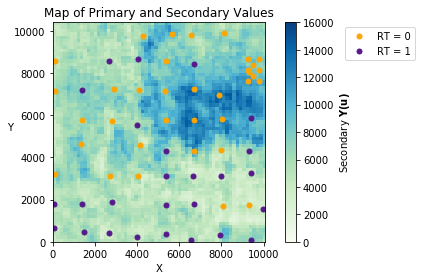

In [4]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, aspect='equal')

# Secondary measurements
cax = ax.imshow(gridded, origin='lower', extent=[XMIN, XMAX, YMIN, YMAX], aspect='equal',
                interpolation='none', vmin=SMIN, vmax=SMAX, cmap='GnBu')
cbar = fig.colorbar(cax, label=r'Secondary $\bf{Y(u)}$')

# Primary rocktype measurements
for rt, rtcolor in zip(RTS, RTCOLORS):
    ax.plot(data[data['RT'] == rt]['X'], data[data['RT'] == rt]['Y'], '.',
            ms=10, c=rtcolor, label='RT = {}'.format(rt))

ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(1.35,1))

ax.set_xlabel('X')
ax.set_xlim((XMIN, XMAX))
ax.set_ylabel('Y', rotation=0)
ax.set_ylim((YMIN, YMAX))
ax.set_title('Map of Primary and Secondary Values')

plt.tight_layout()
plt.savefig('map_of_primary_and_secondary_values.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()

## Declustering for $P(A)$

Sampling of the rocktype is not equal, and is clustered in the upper right hand corner of the map. Declustering is therefore necessary to infer a representative distribution of $Z(\mathbf{u})$.  

Two functions are implemented below for random cell declustering of 2D data. These are not written for maximum performance, but instead to illustrate how cell declustering works. Using the JIT compiler from numba greatly improves the runtime.

In [5]:
@jit(nopython=True)
def cell_declus(x, y, cellsize):
    '''Calculate weights given a cell size for a random restart with data coordinates'''
    wts = np.ones(len(x))
    
    # Define an initial accumulator for cell ids
    cellids = np.zeros(len(x))
    
    # Define a lower origin to use for the cell sizes
    x_origin = np.min(x) - (1 + np.random.rand())*cellsize
    y_origin = np.min(y) - (1 + np.random.rand())*cellsize
    
    # Calculate the maximum number of possible cells
    nx = int(np.ceil((np.max(x) - x_origin)/cellsize) + 1)
    ny = int(np.ceil((np.max(y) - y_origin)/cellsize) + 1)

    # Determine which cell each value falls inside
    for idx, (xval, yval) in enumerate(zip(x, y)):
        # Get the indices - we don't need to check for a minimum edge since we force the grid lower
        ix = int(np.ceil((xval - x_origin) / cellsize + 0.5)) - 1
        iy = int(np.ceil((yval - y_origin) / cellsize + 0.5)) - 1
        # Get the cell index
        cellids[idx] = int(ix + iy*nx)
    
    # Determine number of data within each cell
    # The weight of a cell is inversely proportional to the number of ids in that cell
    for idx, cellid in enumerate(cellids):
        wts[idx] = 1.0/(cellids == cellid).sum()
    
    return wts

@jit
def cell_decluster_2d(x, y, var, cellsize, nrestarts=200):
    '''Perform square cell declustering on 2 dimensional data
    
    Returns the mean and a vector of weights for each location.
    Weights sum to the number of input data'''
    assert len(x) == len(y) == len(var)
    assert cellsize > 0
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    if isinstance(var, pd.Series):
        var = var.values
    
    # Weights are accumulated over the number of restarts and normalized at the end
    wts = np.zeros(len(var))
    for _ in range(nrestarts):
        wts += cell_declus(x, y, cellsize)
    
    # Normalize weights
    wts = wts*(len(wts)/np.sum(wts))
    mean = np.average(var, weights=wts)
    
    return wts, mean

The cell size is chosen to be 1000 units based on the data spacing. For more information, see the <a href="http://geostatisticslessons.com/lessons/celldeclustering.html">lesson on declustering</a>

In [6]:
CELLSIZE = 1000.0 # This cell size was chosen based on the data spacing, see the lesson on declustering

wts, mean = cell_decluster_2d(data['X'], data['Y'], data['RT'], CELLSIZE)

# Declustered proportions are:
rtprops = (1-mean, mean)

print('Original proportion of RT=0 = {:.3f} and RT=1 = {:.3f}'.format(len(data[data['RT'] == 0])/len(data), len(data[data['RT'] == 1])/len(data)))
print('Declustered proportion of RT=0 = {:.3f} and RT=1 = {:.3f}'.format(rtprops[0], rtprops[1]))

Original proportion of RT=0 = 0.574 and RT=1 = 0.426
Declustered proportion of RT=0 = 0.529 and RT=1 = 0.471


Declustering lowered the inferred proportion of $A$ (RT=0) by 5%, which intuitively makes sense based on the cluster of $A$ in the upper right hand quadrant of the map. A map of the declustering weights is made to verify this distribution is reasonable.

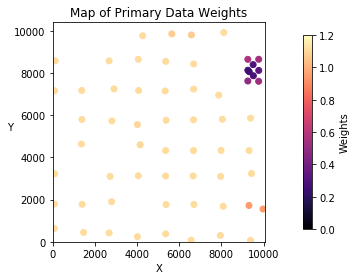

In [7]:
# Map of weights to verify spatial distribution of weights is reasonable
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, aspect='equal')

cm = plt.get_cmap('magma')
cnorm = mpl.colors.Normalize(vmin=0.0, vmax=1.2)
scalarMap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

ax.scatter(data['X'], data['Y'], c=scalarMap.to_rgba(wts))

scalarMap.set_array(wts)
fig.colorbar(scalarMap, fraction=0.026, pad=0.1, label='Weights')

#ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(1.35,1))

ax.set_xlabel('X')
ax.set_xlim((XMIN, XMAX))
ax.set_ylabel('Y', rotation=0)
ax.set_ylim((YMIN, YMAX))
ax.set_title('Map of Primary Data Weights')

plt.tight_layout()
plt.show()

# Distributions

Likelihood distributions of $Y$ are estimated using kernel density estimation.

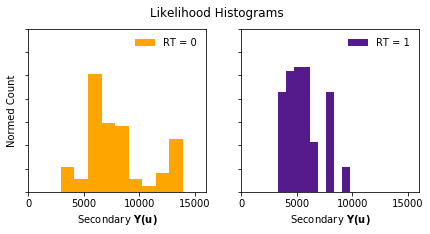

In [8]:
fig = plt.figure(figsize=(7,3))

histymax = 0.00035

for idx, (rt, rtcolor) in enumerate(zip(RTS, RTCOLORS)):
    ax = fig.add_subplot(1, 2, idx+1)
    ax.hist(data[data['RT'] == rt]['Secondary'], weights=wts[data['RT'] == rt], bins=9,
            normed=True, color=rtcolor, label='RT = {}'.format(rt))

    ax.legend(frameon=False, loc='upper right')
    
    ax.set_xlim((SMIN, SMAX))
    ax.set_xlabel(r'Secondary $\bf{Y(u)}$')
    
    ax.set_ylim((0,histymax))
    ax.yaxis.set_ticklabels([])
    if idx == 0:
        ax.set_ylabel('Normed Count')

plt.suptitle('Likelihood Histograms')
plt.savefig('likelihood_histograms.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()

In [9]:
kdes = []
for rt in RTS:
    kde = sm.nonparametric.KDEUnivariate(data[data['RT'] == rt]['Secondary'])
    kde.fit(weights=wts[data['RT'] == rt], fft=False, kernel='gau', bw='silverman', gridsize=1000)
    kdes.append(kde)
    print('Bandwidth of {:.1f} estimated for RT = {}'.format(kde.bw, rt))

Bandwidth of 839.8 estimated for RT = 0
Bandwidth of 543.8 estimated for RT = 1


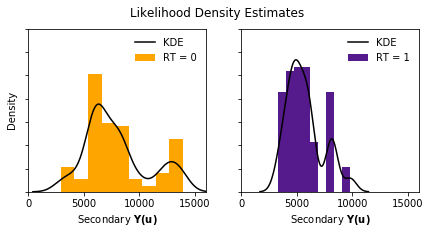

In [10]:
fig = plt.figure(figsize=(7,3))

histymax = 0.00035

for idx, (rt, rtcolor, kde) in enumerate(zip(RTS, RTCOLORS, kdes)):
    ax = fig.add_subplot(1, 2, idx+1)
    ax.hist(data[data['RT'] == rt]['Secondary'], weights=wts[data['RT'] == rt], bins=9,
            normed=True, color=rtcolor, label='RT = {}'.format(rt))
    ax.plot(kde.support, kde.density, lw=1.5, color='black', label='KDE')
    
    ax.legend(frameon=False, loc='upper right')
    
    ax.set_xlim((SMIN, SMAX))
    ax.set_xlabel(r'Secondary $\bf{Y(u)}$')
    
    ax.set_ylim((0,histymax))
    ax.yaxis.set_ticklabels([])
    if idx == 0:
        ax.set_ylabel('Density')

plt.suptitle('Likelihood Density Estimates')
plt.savefig('likelihood_density_estimates.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()

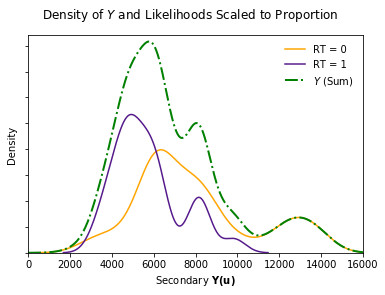

In [11]:
y_kde = sm.nonparametric.KDEUnivariate(data['Secondary'])
y_kde.fit(weights=wts, fft=False, kernel='gau', bw='silverman', gridsize=1000)

histymax = 0.00021

fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)

for idx, (rt, rtcolor, kde, rtprop) in enumerate(zip(RTS, RTCOLORS, kdes, rtprops)):
    ax.plot(kde.support, kde.density*rtprop, lw=1.5, color=rtcolor, label='RT = {}'.format(rt))

# KDE fit of Y = P(Y)
#ax.plot(y_kde.support, y_kde.density, lw=2, ls='--', color='black', label='$Y$ (KDE)')

# P(Y) = P(Y|A)*P(A) + P(Y|!A)*P(!A)
xdisc = np.linspace(0,20000,20000)
ydisc = kdes[0].evaluate(xdisc)*rtprops[0]+kdes[1].evaluate(xdisc)*rtprops[1]
ax.plot(xdisc, ydisc,
        lw=2, ls='-.', color='green', label='$Y$ (Sum)')

ax.legend(frameon=False, loc='upper right')

ax.set_xlim((SMIN, SMAX))
ax.set_xlabel(r'Secondary $\bf{Y(u)}$')

ax.set_ylim((0,histymax))
ax.yaxis.set_ticklabels([])
ax.set_ylabel('Density')

plt.suptitle(r'Density of $Y$ and Likelihoods Scaled to Proportion')
plt.savefig('likelihood_distributions.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()

# Posterior Probabilities $P(A({\bf u})|y({\bf u}))$

Calculating the posterior probabilities $P(A({\bf u})|y({\bf u}))$ is straightforward with the prior probability and the likelihood distributions.  The probability of $\overline{A}$ is one minus this probability.

$P(A(u)|y(u))=P(A)⋅1/fY(y(u))⋅fY|A(y(u))u∈Domain$

In [12]:
# We flip between our gridded shape, and back. An assert is used here to verify that the reshape matches
grid_flat = np.reshape(gridded, [65*63], order='C')
grid_back = np.reshape(grid_flat, [65, 63], order='C')
assert np.allclose(grid_back, gridded)

condprob = np.reshape(kdes[1].evaluate(grid_flat), [65, 63], order='C')

posterior_gridded = rtprops[1]/np.interp(gridded, xdisc, ydisc)*condprob

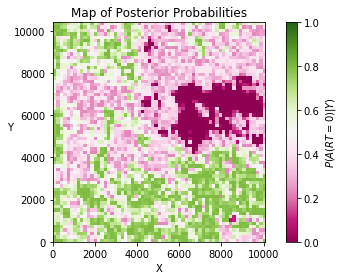

In [13]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, aspect='equal')

# Posterior probabilities
cax = ax.imshow(posterior_gridded, origin='lower', extent=[XMIN, XMAX, YMIN, YMAX], aspect='equal',
                interpolation='none', vmin=0, vmax=1, cmap='PiYG')
cbar = fig.colorbar(cax, label=r'$P(A (RT=0)|Y)$')

ax.set_xlabel('X')
ax.set_xlim((XMIN, XMAX))
ax.set_ylabel('Y', rotation=0)
ax.set_ylim((YMIN, YMAX))
ax.set_title('Map of Posterior Probabilities')

plt.tight_layout()
plt.savefig('posterior_probability_map.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()

# Covariance Calculation

Grouped pairwise distances are used to estimate the covariances everywhere. 

In [14]:
pairwise_distances = squareform(pdist(data[['X','Y']].values, 'euclidean'))
products = np.outer(data[['RT']].values, data[['RT']].values)

steps = [0, 0.1] + np.linspace(800,5000,7).tolist()
bins = [(lower, steps[idx+1]) for idx, lower in enumerate(steps[:-1])]
covariances = []
distances = []

for (lower, upper) in bins:
    covariances.append(np.mean(products[(pairwise_distances >= lower) & (pairwise_distances < upper)]) - rtprops[1]*rtprops[1])
    distances.append(np.mean(pairwise_distances[(pairwise_distances >= lower) & (pairwise_distances < upper)]))

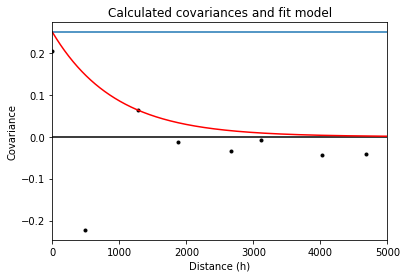

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

sill = rtprops[1]*(1-rtprops[1])

ax.axhline(sill)
ax.axhline(0, color='black')
ax.plot(distances, covariances, 'k.')

def covamodel(vector, std=False, vrange=2800):
    '''The fitted covariance model - may return either the standardized or non-standard covariance'''
    if std:
        return np.exp(-3.0*vector/vrange)
    else:
        return sill*np.exp(-3.0*vector/vrange)

xdis = np.linspace(0,5000,1000)
ydis = covamodel(xdis)
ax.plot(xdis, ydis, 'r-')

ax.set_xlim((0,5000))
ax.set_xlabel('Distance (h)')
ax.set_ylabel('Covariance')
ax.set_title('Calculated covariances and fit model')

plt.savefig('fitted_covariance_model.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()

# Local Conditioning

The posterior calculated above is posterior in the context of the secondary data alone, but there are local conditioning data that should be considered. Indicator kriging is used to estimate probabilities.

In [16]:
# Build the covariance matrix
cmat = np.eye(pairwise_distances.shape[0]+1,pairwise_distances.shape[0]+1)
cmat[0:pairwise_distances.shape[0],0:pairwise_distances.shape[0]] = covamodel(pairwise_distances, std=True)

# Invert the covariance matrix, and multiply by the data values to get the dual kriging weights
cinverse = np.linalg.inv(cmat)
avector = np.append(data['RT'].values, [0])
mmult = np.matmul(cinverse, avector)

In [17]:
# Dual kriging of each location
for rowidx, row in grid.iterrows():
    grid.loc[rowidx, 'Prob'] = np.dot(mmult,np.append(covamodel(cdist(data[['X','Y']].values, 
                                                     np.reshape(row[['X','Y']].values, (1,2)),
                                                     'euclidean'), std=True), [1]))

# A minimum indicator probability is required for permanence of ratios
# 0.1% is chosen here
grid['Prob'] = np.where(grid['Prob'] <= 0, 0.001, grid['Prob'])
grid['Prob'] = np.where(grid['Prob'] > 1, 1, grid['Prob'])

griddedprobs = np.reshape(grid.sort_values(by=['Y', 'X'], axis=0, ascending=True)['Prob'].values,
                     [65, 63], order='C')

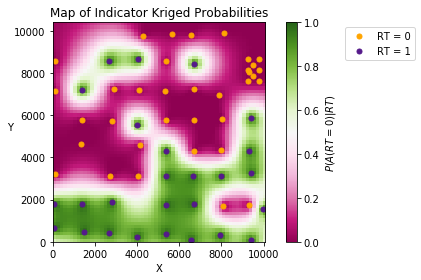

In [18]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, aspect='equal')

# Indicator kriged probabilities
cax = ax.imshow(griddedprobs, origin='lower', extent=[XMIN, XMAX, YMIN, YMAX], aspect='equal',
                interpolation='none', vmin=0, vmax=1, cmap='PiYG')
cbar = fig.colorbar(cax, label=r'$P(A (RT=0)|RT)$')

# Primary rocktype measurements
for rt, rtcolor in zip(RTS, RTCOLORS):
    ax.plot(data[data['RT'] == rt]['X'], data[data['RT'] == rt]['Y'], '.',
            ms=10, c=rtcolor, label='RT = {}'.format(rt))

ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(1.35,1))

ax.set_xlabel('X')
ax.set_xlim((XMIN, XMAX))
ax.set_ylabel('Y', rotation=0)
ax.set_ylim((YMIN, YMAX))
ax.set_title('Map of Indicator Kriged Probabilities')

plt.tight_layout()
plt.savefig('indicator_probability_map.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()

# Permanence of ratios

Combining local conditioning and secondary data at the same time is a challenge given the unique data configuration for each location. Permanence of ratios is used for the combination here.

$$ 
\phi ( P(A), P(A|B), P(A|C) ) = \frac{ \frac{1-P(A)}{P(A)} }
{ \frac{1-P(A)}{P(A)}+\frac{1-P(A|B)}{P(A|B)} \cdot \frac{1-P(A|C)}{P(A|C)} }
$$


In [19]:
p_a_ratio = (1.0 - rtprops[1])/(rtprops[1])
p_b_ratio = (1.0 - posterior_gridded)/posterior_gridded
p_c_ratio = (1.0 - griddedprobs)/griddedprobs

permratio = (p_a_ratio)/(p_a_ratio + p_b_ratio*p_c_ratio)

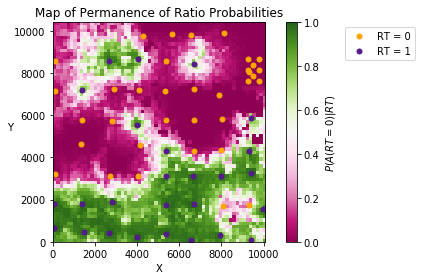

In [20]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, aspect='equal')

# Combined probabilities
cax = ax.imshow(permratio, origin='lower', extent=[XMIN, XMAX, YMIN, YMAX], aspect='equal',
                interpolation='none', vmin=0, vmax=1, cmap='PiYG')
cbar = fig.colorbar(cax, label=r'$P(A (RT=0)|RT)$')

# Primary rocktype measurements
for rt, rtcolor in zip(RTS, RTCOLORS):
    ax.plot(data[data['RT'] == rt]['X'], data[data['RT'] == rt]['Y'], '.',
            ms=10, c=rtcolor, label='RT = {}'.format(rt))

ax.legend(frameon=True, loc='upper left', bbox_to_anchor=(1.35,1))

ax.set_xlabel('X')
ax.set_xlim((XMIN, XMAX))
ax.set_ylabel('Y', rotation=0)
ax.set_ylim((YMIN, YMAX))
ax.set_title('Map of Permanence of Ratio Probabilities')

plt.tight_layout()
plt.savefig('map_permanence_ratios_probability.png', dpi=600,
            bbox_inches='tight', transparent=True)
plt.show()